# Drug Repurposing using Artificial Intelligence

---
layout: post
title:  "Drug Repurposing using Artificial Intelligence"
date:   2025-04-20 12:00:00 +0100
categories: 
    - AI
    - cheminformatics 
    - data science 
    - drug repurposing
    - machine learning
---

**Abstract goes here**

---

## Drug Repurposing

Traditional drug discovery is a marathon, often taking over a decade and requiring an investment of more than a billion dollars for each successful drug. This lengthy and costly process shows the urgent need for more efficient strategies to combat disease. One such promising stategy is drug repurposing, identifying new therapeutic uses for existing drugs or those already undergoing clinical trials. By bypassing much of the early-stage development, and sometime significant parts of clinical trials, drug repurposing offers the potential to significantly reduce both the time and financial cost associated with bringing new treatments to patients.

One well known example of drug repurposing is sildenafil, originally developed to treat high blood pressure and angina (chest pain), and was famously repurposed for erectile dysfunction after clinical trials revealed this unexpected side effect. Another is thalidomide. Developed to treat morning sickness and found to cause birth defects, it is now used to treat cancers and skin disorders associated with leprosy. The crucial role of drug repurposing was further highlighted during the recent COVID-19 pandemic, where the corticosteroid dexamethasone emerged as a vital intervention in reducing mortality among severely ill patients.

## The Drug Repurposing Hub

[The Drug Repurposing Hub](https://www.nature.com/articles/nm.4306.epdf), is a curated and annotated collection of drugs that have already received FDA approval or are currently undergoing clinical trials. Maintained by the Broad Institute, this resource serves as both a virtual library, providing comprehensive information on each compound, and a physical library, offering access to compound plates for experimental screening.

## Antibiotic Discovery using Deep Learning 

This post was inspired by the [work of the Collins Lab at MIT](https://www.cell.com/cell/fulltext/S0092-8674(20)30102-1?fbclid=IwAR1HXccciF6clitQSUhVfcoq_3bmeBYm4vhndZabChZORx5bGHUYxuKe04U), who used deep learning techniques to identify potential compounds to be repurposed as treatments for antimicrobial resistant bacteria. Their research addresses the escalating crisis of antibiotic resistance, a looming threat projected to cause 10 million deaths annually by 2050.

To tackle this challenge, the researchers assembled a primary training set of 2,335 molecules, experimentally screening them against _E. coli_ BW25113 and identifying 120 compounds with antimicrobial activity. With the goal of creating a robust and generalizable model, they ensured the training set was structurally diverse. This data was then used to train a directed message-passing neural network (dMPNN) to create a classification model capable of predicting antimicrobial activity based on a molecule's chemical structure. The trained model was subsequently used to make predictions on virtual libraries of compounds, including the Drug Repurposing Hub.

99 molecules from the Drug Repurposing Hub that were predicted active were experimentally tested, with 51 displaying growth inhibition against E. coli. This process led to the identification of a particularly promising compound, the c-Jun N-terminal kinase inhibitor SU3327, which the researchers named halicin. Notably, halicin possesses a structure distinctly different from conventional antibiotics and demonstrated potent inhibitory activity against E. coli growth.

## Chemprop

Central to this research is the open-source software package [Chemprop](https://chemprop.readthedocs.io/en/latest/). Developed primarily by researchers at MIT using the PyTorch framework, Chemprop harnesses the capabilities of message-passing neural networks (MPNNs) for molecular property prediction. Chemprop can be used both as a command-line interface (CLI) and a Python API. It implements a d-MPNN architecture, a type of graph neural network particularly effective for extracting relationships from molecular structures represented as graphs. An advantage of Chemprop is its ability to learn directly from molecular representations, such as SMILES strings converted into molecular graphs, eliminating the need for manual feature engineering, which can also introduce biases.

## ChEMBL

- Without a lab to do experimental testing, used ChEMBL to get publically available data
- Webservice: https://pmc.ncbi.nlm.nih.gov/articles/PMC4489243/

## TODO:

- Diversity analysis of training data

## Imports

In [1]:
from pathlib import Path

import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm

UNIPROT_ID = "P00533"
IC_50_CUTOFF = 25
DRUG_REPURPOSING_HUB_URL = "https://storage.googleapis.com/cdot-general-storage/repurposing_samples_20240610.txt"

Path("data").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

## Getting the data from ChEMBL

In [ ]:
# Get the target for a UniProt ID
targets = new_client.target.get(target_components__accession=UNIPROT_ID).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f"Found {len(targets)} targets for {UNIPROT_ID}")
print("Selecting first target")
target_chembl_id = targets[0]["target_chembl_id"]
pref_name = targets[0]["pref_name"]
print(f"Target name: {pref_name}, ChEMBL ID: {target_chembl_id}")

# Get the bioactivity data for the target
bioactivities = new_client.activity.filter(
    target_chembl_id=target_chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)
bioactivities_df = pd.DataFrame(bioactivities)
bioactivities_df[bioactivities_df.standard_units == "nM"]
bioactivities_df = bioactivities_df.dropna(subset=["standard_value"])
bioactivities_df.standard_value = bioactivities_df.standard_value.astype(float)
bioactivities_df = (
    bioactivities_df[["molecule_chembl_id", "standard_value"]]
    .groupby("molecule_chembl_id")
    .mean()
    .reset_index()
)
print(f"Number of bioactivities: {len(bioactivities_df)}")

# Get the compound data for the ChEMBL IDs
compounds_provider = new_client.molecule.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds_provider = new_client.molecule.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compound_idenitifiers = {
    compound["molecule_chembl_id"]: compound["molecule_structures"]
    for compound in tqdm(compounds_provider)
}


def get_smiles(chembl_id: str, identifier_dict: dict) -> str | None:
    """Get SMILES string from compound identifier dictionary."""
    try:
        return identifier_dict[chembl_id]["canonical_smiles"]
    except (KeyError, TypeError):
        return None


bioactivities_df["smiles"] = bioactivities_df["molecule_chembl_id"].apply(
    get_smiles, args=(compound_idenitifiers,)
)
bioactivities_df = bioactivities_df.dropna(subset=["smiles"]).copy()
bioactivities_df["active"] = bioactivities_df["standard_value"].apply(
    lambda x: 1 if x < IC_50_CUTOFF else 0
)
bioactivities_df = bioactivities_df[["smiles", "active"]]
bioactivities_df.to_csv("data/chembl_target_activity.csv", index=False)

Found 9 targets for P00533
Selecting first target
Target name: Epidermal growth factor receptor erbB1, ChEMBL ID: CHEMBL203
Number of bioactivities: 7391


 19%|█▊        | 1381/7391 [03:52<21:56,  4.56it/s]

## Training a Chemprop Model

In [ ]:
!chemprop train \
    --data-path data/chembl_target_activity.csv \
    --task-type classification \
    --save-dir models/ \
    --features-generator v1_rdkit_2d \
    --split-type scaffold_balanced 

2025-04-20T10:41:59 - INFO:chemprop.cli.main - Running in mode 'train' with args: {'smiles_columns': None, 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'molecule_featurizers': ['v1_rdkit_2d'], 'descriptors_path': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'config_path': None, 'data_path': PosixPath('data/chembl_target_activity.csv'), 'output_dir': PosixPath('models'), 'remove_checkpoints': False, 'checkpoint': None, 'freeze_encoder': False, 'model_frzn': None, 'frzn_ffn_layers': 0, 'ensemble_size': 1, 'message_hidden_dim': 300, 'message_bias': False, 'depth': 3, 'undirected': False, 'dropout': 0.0, 'mpn_shared': False, 'acti

## Download the Drug Repurposing Hub dataset

In [ ]:
def canon_smiles(smiles: str) -> str | None:
    """Convert SMILES string to canonical SMILES."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, canonical=True)


drug_repurposing_df = pd.read_csv(
    DRUG_REPURPOSING_HUB_URL,
    sep="\t",
    skiprows=9,
)
drug_repurposing_df["smiles"] = drug_repurposing_df["smiles"].apply(canon_smiles)
drug_repurposing_df.dropna(subset=["smiles"], inplace=True)
drug_repurposing_df.drop_duplicates(subset=["smiles"], keep="first", inplace=True)
drug_repurposing_df.to_csv("data/drug_repurposing_hub.csv", index=False)
print(f"Number of unique SMILES: {len(drug_repurposing_df['smiles'].unique())}")

Number of unique SMILES: 6734


## Make predictions on the drug repurposing hub data using the trained model

In [ ]:
!chemprop predict \
    --test-path data/drug_repurposing_hub.csv \
    --model-paths models/ \
    --smiles-columns smiles \
    --features-generator v1_rdkit_2d \
    --preds-path data/predictions.csv

2025-04-20T10:50:29 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'molecule_featurizers': ['v1_rdkit_2d'], 'descriptors_path': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'test_path': PosixPath('data/drug_repurposing_hub.csv'), 'output': PosixPath('data/predictions.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath('models')], 'cal_path': None, 'uncertainty_method': 'none', 'calibration_method': None, 'evaluation_methods': None, 'uncertainty_dropout_p': 0.1, 'dropout_sampling_size': 10, 'calibration_interval_percentile': 9

## Visualize the top predictions

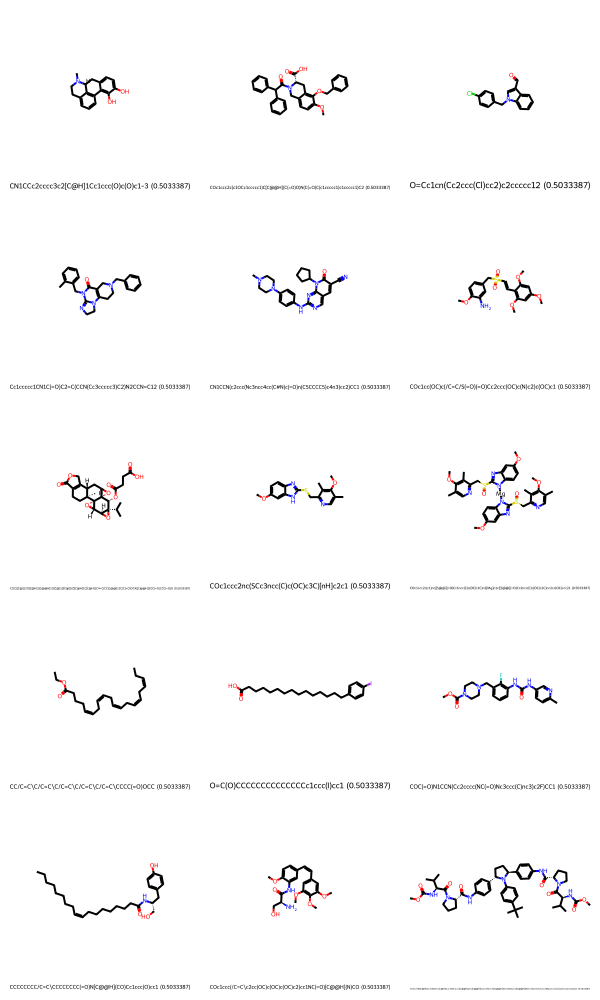

In [ ]:
predictions_df = (
    pd.read_csv("data/predictions.csv").sort_values("active", ascending=False).head(15)
)

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in predictions_df["smiles"]],
    legends=[
        f"{s} ({a})" for s, a in zip(predictions_df["smiles"], predictions_df["active"])
    ],
    molsPerRow=5,
)